# **Mid-term Project: Implementing Object Detection on a Dataset**

## **PERCI, RENZ DEXTER M.** & **REYES, FAVIELLE ANNE O.**
## BSCS-4A IS


## Download all necessary packages

In [1]:
!pip install opencv-python-headless scikit-learn albumentations scikit-image roboflow

In [19]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from skimage.feature import hog
from albumentations import Blur, MedianBlur, ToGray, CLAHE, Compose
import glob
from roboflow import Roboflow
import time
import matplotlib.pyplot as plt

## 1. Selection of Dataset and Algorithm:

In [3]:
rf = Roboflow(api_key="7oi7vCGH7qZHNdiDXDax")
project = rf.workspace("tutorial-knlj8").project("chess-board-detection-uuppk")
version = project.version(4)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


#### 2. Implementation

##### 2.1 Data Preparation

In [24]:
# Function to load images and their corresponding labels
def load_yolov5_data(images_folder, annotations_folder):
    X = []  # Features
    y = []  # Labels
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.jpg')])
    annotation_files = sorted([f for f in os.listdir(annotations_folder) if f.endswith('.txt')])

    for img_file, ann_file in zip(image_files, annotation_files):
        image_path = os.path.join(images_folder, img_file)
        annotation_path = os.path.join(annotations_folder, ann_file)

        # Load the image
        image = cv2.imread(image_path)
        labels = []

        # Read the annotation file
        with open(annotation_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                class_id = int(parts[0])
                labels.append(class_id)

        if labels and image is not None:
            image_resized = cv2.resize(image, (64, 128))
            X.append(image_resized)
            y.append(labels)

    return X, y

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    return hog_features

# Define the augmentations using Albumentations
augmentation = Compose([
    Blur(p=0.01, blur_limit=(3, 7)),
    MedianBlur(p=0.01, blur_limit=(3, 7)),
    ToGray(p=0.01, num_output_channels=3, method='weighted_average'),
    CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
])

# Paths to your dataset
base_folder = '/content/Chess-Board-Detection-4'
train_images_folder = os.path.join(base_folder, 'train', 'images')
train_labels_folder = os.path.join(base_folder, 'train', 'labels')
valid_images_folder = os.path.join(base_folder, 'valid', 'images')
valid_labels_folder = os.path.join(base_folder, 'valid', 'labels')
test_images_folder = os.path.join(base_folder, 'test', 'images')
test_labels_folder = os.path.join(base_folder, 'test', 'labels')

# Load the datasets
X_train, y_train = load_yolov5_data(train_images_folder, train_labels_folder)
X_valid, y_valid = load_yolov5_data(valid_images_folder, valid_labels_folder)
X_test, y_test = load_yolov5_data(test_images_folder, test_labels_folder)

# Use MultiLabelBinarizer for multi-label classification
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_valid_encoded = mlb.transform(y_valid)
y_test_encoded = mlb.transform(y_test)

# Convert the feature lists to NumPy arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

# Prepare lists for HOG features after augmentation
X_train_hog = []
y_train_hog = []

# Generate augmented images and extract HOG features
for i in range(X_train.shape[0]):
    augmented = augmentation(image=X_train[i])
    augmented_image = augmented['image']
    hog_features = extract_hog_features(augmented_image)
    if hog_features is not None:
        X_train_hog.append(hog_features)
        y_train_hog.append(y_train_encoded[i])

# Convert to numpy arrays
X_train_flattened = np.array(X_train_hog)
y_train_flattened = np.array(y_train_hog)

# Flatten HOG features for validation and test datasets
X_valid_flattened = np.array([extract_hog_features(x) for x in X_valid])
X_test_flattened = np.array([extract_hog_features(x) for x in X_test])

# Scale features
scaler = StandardScaler()
X_train_flattened = scaler.fit_transform(X_train_flattened)
X_valid_flattened = scaler.transform(X_valid_flattened)
X_test_flattened = scaler.transform(X_test_flattened)

##### 2.2 Model Building

In [25]:
# Use Stratified K-Fold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize OneVsRestClassifier with LinearSVC
classifier = OneVsRestClassifier(LinearSVC(class_weight='balanced', max_iter=10000))

##### 2.3 Training the Model

In [26]:
# Train the SVM classifier
start_time = time.time()
classifier.fit(X_train_flattened, y_train_flattened)
training_time_hog_svm = time.time() - start_time

print(f"Training time: {training_time_hog_svm:.4f} seconds")

Training time: 0.6703 seconds


##### 2.4 Testing

In [27]:
%%bash
cat <<EOF >> /content/labelmap.txt
black-camel
black-elephant
black-horse
black-king
black-pawn
black-queen
white-camel
white-elephant
white-horse
white-king
white-pawn
white-queen
EOF

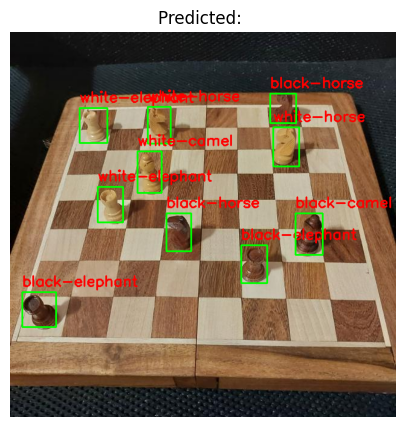

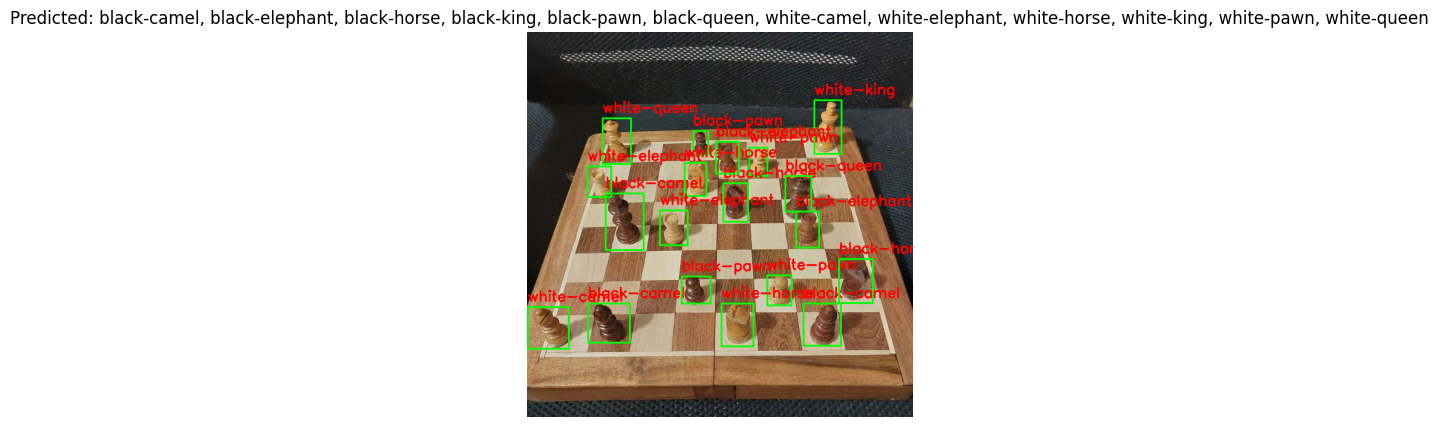

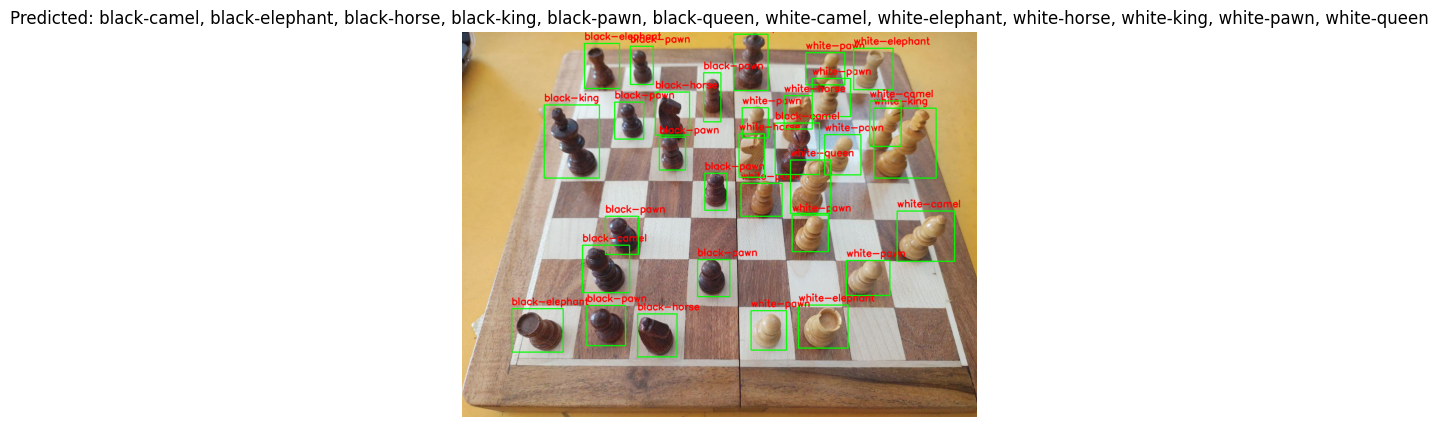

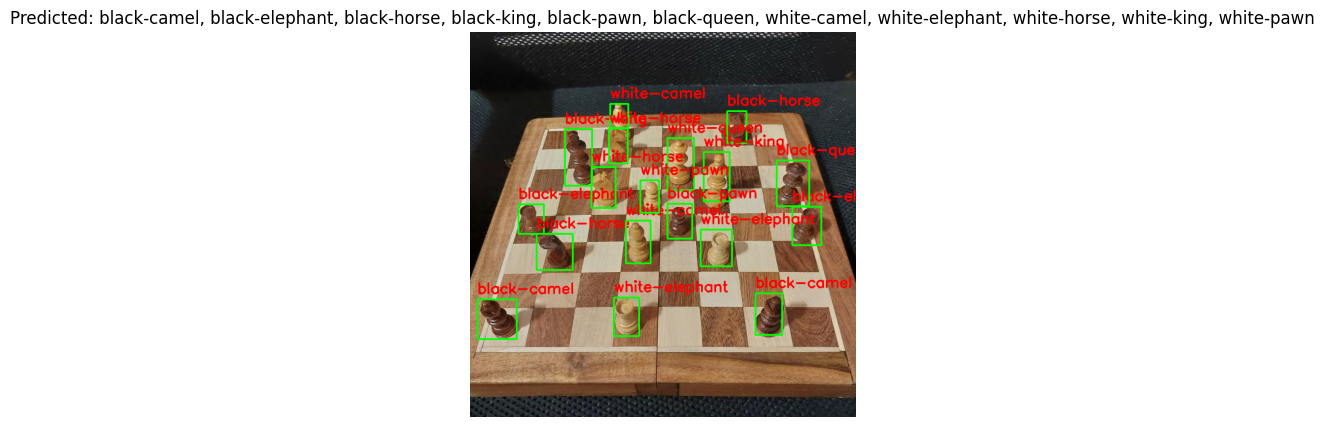

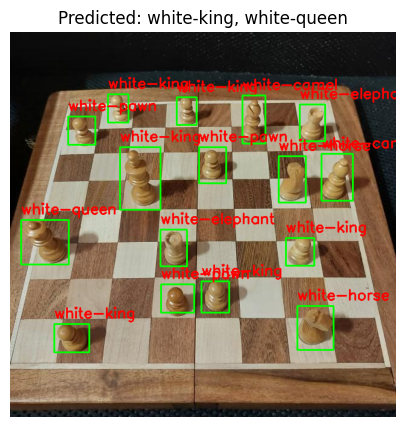

In [28]:
# Function to load class names from labelmap.txt
def load_class_names(labelmap_path):
    with open(labelmap_path, 'r') as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Function to parse YOLO annotations
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                x_center, y_center, width, height = (
                    x_center * img_width,
                    y_center * img_height,
                    width * img_width,
                    height * img_height
                )
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                bboxes.append((x_min, y_min, x_max, y_max, int(class_id)))
    return bboxes

# Function to visualize predictions
def visualize_predictions(image_dir, annotations_dir, classifier, scaler, class_names, limit=10):
    count = 0
    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Extract HOG features for the entire image
        image_resized = cv2.resize(image, (64, 128))
        hog_features = extract_hog_features(image_resized)
        hog_features = scaler.transform([hog_features])

        # Predict the class using the trained classifier
        prediction = classifier.predict(hog_features)
        predicted_labels = [class_names[i] for i in np.where(prediction[0] == 1)[0]]

        # Draw the actual bounding boxes on the original image
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, class_id = bbox
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label = class_names[class_id] if class_id < len(class_names) else 'Unknown'
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Display the image with bounding boxes and predicted labels
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Predicted: {', '.join(predicted_labels)}")
        plt.show()

        count += 1
        if count >= limit:
            break

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    return hog_features

# Load class names from labelmap.txt
labelmap_path = '/content/labelmap.txt'
class_names = load_class_names(labelmap_path)

# Example usage (adjust with your actual directories and trained model)
visualize_predictions(test_images_folder, test_labels_folder, classifier, scaler, class_names, limit=10)

Inference Time for /content/Chess-Board-Detection-4/test/images/20230315_195331_jpg.rf.d4e8d549a869a7b3cf03aa58b18ecb85.jpg: 0.0154 seconds
Predicted Labels: []


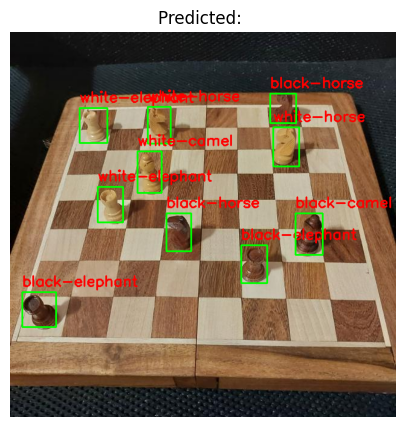

Inference Time for /content/Chess-Board-Detection-4/test/images/20230315_194307_jpg.rf.20dcc57ba2dcfdd1ca6c921cd3fc6c14.jpg: 0.0099 seconds
Predicted Labels: ['black-camel', 'black-elephant', 'black-horse', 'black-king', 'black-pawn', 'black-queen', 'white-camel', 'white-elephant', 'white-horse', 'white-king', 'white-pawn', 'white-queen']


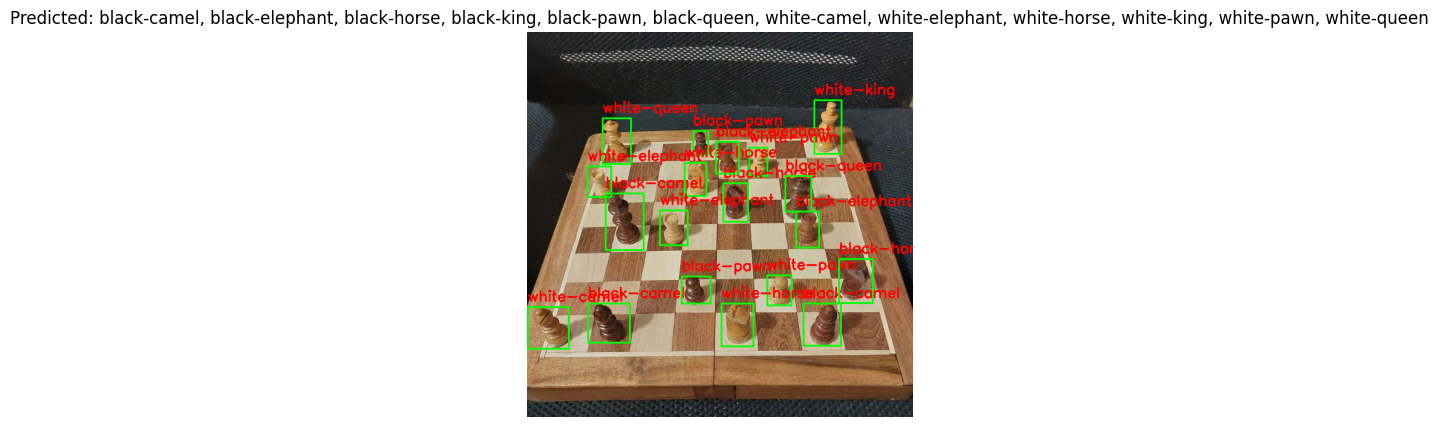

Inference Time for /content/Chess-Board-Detection-4/test/images/photo_2023-03-07-12-31-27_jpeg.rf.f0e8a63e3376386e3163dd79d7499054.jpg: 0.0190 seconds
Predicted Labels: ['black-camel', 'black-elephant', 'black-horse', 'black-king', 'black-pawn', 'black-queen', 'white-camel', 'white-elephant', 'white-horse', 'white-king', 'white-pawn', 'white-queen']


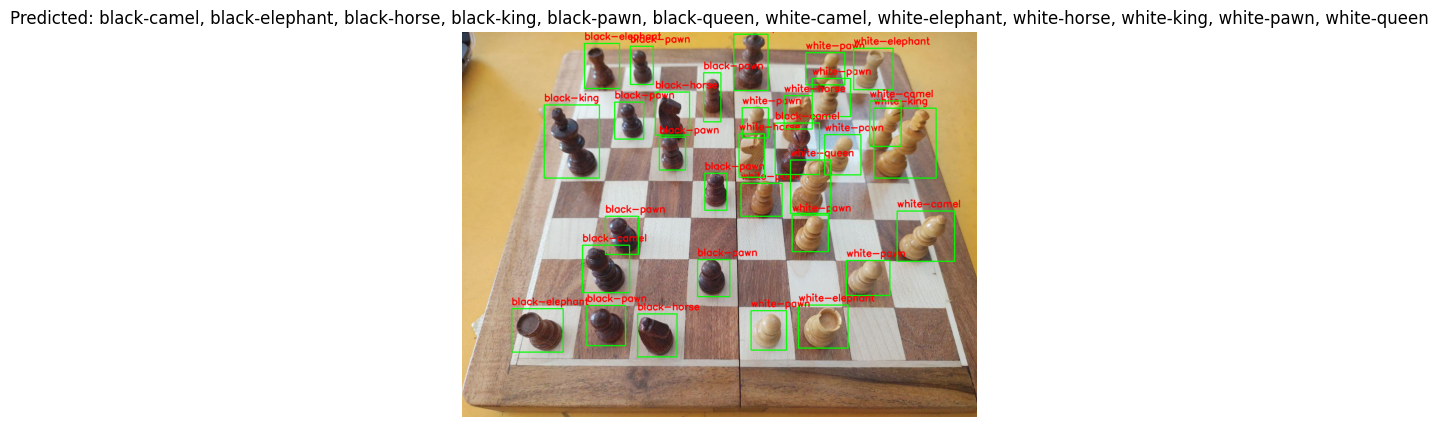

Inference Time for /content/Chess-Board-Detection-4/test/images/20230315_195425_jpg.rf.ade863ff45e600f66303e669849b0ff9.jpg: 0.0353 seconds
Predicted Labels: ['black-camel', 'black-elephant', 'black-horse', 'black-king', 'black-pawn', 'black-queen', 'white-camel', 'white-elephant', 'white-horse', 'white-king', 'white-pawn']


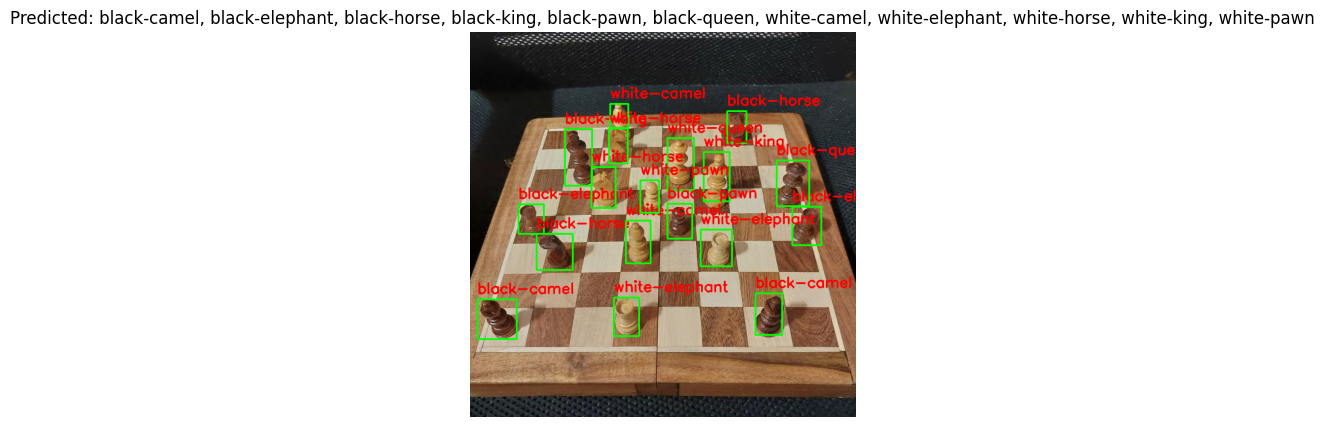

Inference Time for /content/Chess-Board-Detection-4/test/images/20230315_193509_jpg.rf.6a788bb87d85fc2661fdec5a6f4c0a6b.jpg: 0.0091 seconds
Predicted Labels: ['white-king', 'white-queen']


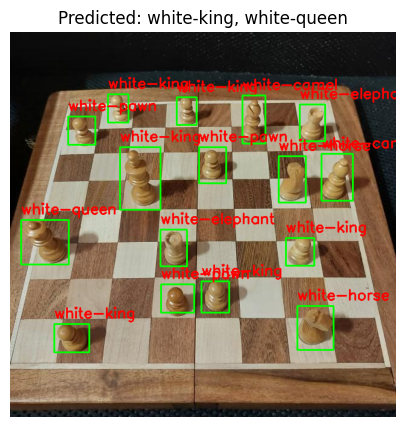

Average Inference Time for folder: 0.0178 seconds


In [29]:
# Function to load class names from labelmap.txt
def load_class_names(labelmap_path):
    with open(labelmap_path, 'r') as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Function to parse YOLO annotations
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                x_center, y_center, width, height = (
                    x_center * img_width,
                    y_center * img_height,
                    width * img_width,
                    height * img_height
                )
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                bboxes.append((x_min, y_min, x_max, y_max, int(class_id)))
    return bboxes

# Function to visualize predictions
def visualize_predictions(image_dir, annotations_dir, classifier, scaler, class_names, limit=10):
    count = 0
    total_inference_time = 0

    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Start timing the inference
        start_time = time.time()

        # Extract HOG features for the entire image
        image_resized = cv2.resize(image, (64, 128))
        hog_features = extract_hog_features(image_resized)
        hog_features = scaler.transform([hog_features])

        # Predict the class using the trained classifier
        prediction = classifier.predict(hog_features)
        predicted_labels = [class_names[i] for i in np.where(prediction[0] == 1)[0]]

        # End timing the inference
        inference_time = time.time() - start_time
        total_inference_time += inference_time

        # Print inference time and predicted labels
        print(f"Inference Time for {image_path}: {inference_time:.4f} seconds")
        print(f"Predicted Labels: {predicted_labels}")

        # Draw the actual bounding boxes on the original image
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, class_id = bbox
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label = class_names[class_id] if class_id < len(class_names) else 'Unknown'
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Display the image with bounding boxes and predicted labels
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Predicted: {', '.join(predicted_labels)}")
        plt.show()

        count += 1
        if count >= limit:
            break

    # Print average inference time
    if count > 0:
        average_inference_time = total_inference_time / count
        print(f"Average Inference Time for folder: {average_inference_time:.4f} seconds")

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    return hog_features

# Load class names from labelmap.txt
labelmap_path = '/content/labelmap.txt'
class_names = load_class_names(labelmap_path)

# Example usage (adjust with your actual directories and trained model)
visualize_predictions(test_images_folder, test_labels_folder, classifier, scaler, class_names, limit=10)

#### 3. Evaluation (Performance Metrics)

In [22]:
# Load class names from labelmap.txt
labelmap_path = '/content/labelmap.txt'
class_names = load_class_names(labelmap_path)

# Ensure class_names matches the number of classes in the model
if len(class_names) != len(mlb.classes_):
    print("Warning: The number of class names does not match the number of classes in the model.")
    class_names = [class_names[i] for i in range(len(mlb.classes_))]

# Evaluate the classifier on training, validation, and test sets
y_pred_train = classifier.predict(X_train_flattened)
y_pred_valid = classifier.predict(X_valid_flattened)
y_pred_test = classifier.predict(X_test_flattened)

# Print classification report and accuracy for the training set
print("\nTraining Classification Report:")
print(classification_report(y_train_encoded, y_pred_train, target_names=class_names, zero_division=0))
print("Training Accuracy:", accuracy_score(y_train_encoded, y_pred_train))

# Print classification report and accuracy for the validation set
print("\nValidation Classification Report:")
print(classification_report(y_valid_encoded, y_pred_valid, target_names=class_names, zero_division=0))
print("Validation Accuracy:", accuracy_score(y_valid_encoded, y_pred_valid))

# Initialize a list to collect overall inference times
overall_inference_times = []

# List of folders to test
folders_to_test = [test_images_folder]  # Add more folders if needed

# Loop through each folder in folders_to_test
for new_images_folder in folders_to_test:
    print(f"\nTesting folder: {new_images_folder}")

    # Get image paths from the current folder
    image_paths = glob.glob(os.path.join(new_images_folder, "*.jpg"))

    # Initialize total inference time
    total_inference_time = 0
    num_images = len(image_paths)

    # Classify objects in the current folder
    for image_path in image_paths:
        # Load and preprocess the image
        image = cv2.imread(image_path)
        image_resized = cv2.resize(image, (64, 128))  # Resize to the same size used for training

        # Extract HOG features
        hog_features = extract_hog_features(image_resized)

        # Scale the features using the same scaler used during training
        hog_features = scaler.transform([hog_features])

        # Predict the class using the trained classifier
        start_time = time.time()
        prediction = classifier.predict(hog_features)
        end_time = time.time()

        # Measure inference time
        inference_time = end_time - start_time
        total_inference_time += inference_time  # Accumulate total inference time

    # Calculate and print average inference time for the folder
    average_inference_time = total_inference_time / num_images if num_images > 0 else 0
    overall_inference_times.append(total_inference_time)  # Collect total inference time for averaging
    print(f"\nAverage Inference Time for folder {new_images_folder}: {average_inference_time:.4f} seconds\n")

# Calculate overall average inference time across all test folders
overall_average_inference_time = sum(overall_inference_times) / len(overall_inference_times) if overall_inference_times else 0

# Print classification report and accuracy for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=class_names, zero_division=0))
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test))

# Print overall average inference time
print(f"\nOverall Average Inference Time across test folders: {overall_average_inference_time:.4f} seconds")


Training Classification Report:
                precision    recall  f1-score   support

   black-camel       1.00      1.00      1.00        51
black-elephant       1.00      1.00      1.00        51
   black-horse       1.00      1.00      1.00        51
    black-king       1.00      1.00      1.00        51
    black-pawn       1.00      1.00      1.00        39
   black-queen       1.00      1.00      1.00        51
   white-camel       1.00      1.00      1.00        54
white-elephant       1.00      1.00      1.00        51
   white-horse       1.00      1.00      1.00        51
    white-king       1.00      1.00      1.00        57
    white-pawn       1.00      1.00      1.00        42
   white-queen       1.00      1.00      1.00        54

     micro avg       1.00      1.00      1.00       603
     macro avg       1.00      1.00      1.00       603
  weighted avg       1.00      1.00      1.00       603
   samples avg       1.00      1.00      1.00       603

Training Acc

In [20]:
# Model evaluation on validation set
y_valid_pred = classifier.predict(X_valid_flattened)

# Calculate performance metrics
val_accuracy = accuracy_score(y_valid_encoded, y_valid_pred)
val_precision = precision_score(y_valid_encoded, y_valid_pred, average='macro')
val_recall = recall_score(y_valid_encoded, y_valid_pred, average='macro')

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

# Model evaluation on test set
y_test_pred = classifier.predict(X_test_flattened)

# Calculate performance metrics for the test set
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='macro')
test_recall = recall_score(y_test_encoded, y_test_pred, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

# Speed Evaluation
start_time = time.time()
_ = classifier.predict(X_test_flattened)  # Just for timing
detection_time = time.time() - start_time
print("Detection time for test set:", detection_time)

Validation Accuracy: 0.16666666666666666
Validation Precision: 0.8402777777777777
Validation Recall: 0.6138888888888889
Test Accuracy: 0.2
Test Precision: 0.9722222222222222
Test Recall: 0.7958333333333334
Detection time for test set: 0.005112171173095703
